# <font color='orange'>Catégorisez automatiquement des questions</font>

##  <font color='navy'>Sommaire

**Partie 1 : Construction du Bag-of-words**
- <a href="#C1">Récupération des données</a>
- <a href="#C5">Nettoyage des données texte</a>
- <a href="#C10">Vectorisation du texte</a>
- <a href="#C15">Exploration des données</a>

**Partie 2 : Modelisation non supervisée**
- <a href="#http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?C1">Préparation des données.</a>
    - <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C11"> Transformation des données pour BoW</a>
    - <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C12"> Transformation des données pour Tf-idf</a>
- <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C5">LDA</a>
    - <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C51"> LDA + BoW</a>
    - <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C52"> LDA + Tf-idf</a>
    - <a href="http://localhost:8888/notebooks/OCR%20-%20IML/P5%20-%20Cat%C3%A9gorisez%20automatiquement%20des%20questions/Jouvin_Flavie_3_notebook_approche_non_supervis%C3%A9e_052024.ipynb?#C53"> Visualisation avec LDAvis</a>

# <font color='navy'>PARTIE 1 - Construction du Bag-of-words</font>

**Quelques définitions pour introduire l'analyse de données texte.**

- Le corpus : un ensemble de documents (des textes dans notre cas), regroupés dans une optique ou dans une thématique précise. 

- Un document : la notion de document fait référence à un texte appartenant au corpus, mais indépendant des autres textes. Il peut être constitué d'une ou plusieurs phrases, un ou plusieurs paragraphes.

- Un token : le terme token désigne généralement un mot et/ou un élément de ponctuation. La phrase "Hello World!" comprend donc 3 tokens. 

- Le vocabulaire : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus.

#### <font color='orange'>**Import des librairies python.**</font>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import swifter
import re
import string
import random
import contractions
from collections import Counter
import pickle
from scipy import sparse
import logging
import gensim

# Détection du langage.
import langdetect 
from langdetect import detect

from collections import Counter
from bs4 import BeautifulSoup

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fonctions.
import importlib

import preprocessing_config
importlib.reload(preprocessing_config)
from preprocessing_config import (
    language_names, 
    seuil_representation_top_langage, 
    seuil_min_rare_word,
    top_N,
    min_occurrences
)

import preprocessing_fonctions
importlib.reload(preprocessing_fonctions)
from preprocessing_fonctions import (
    clean_text,
    detect_language_and_analyze,
    filter_top_language,
    preprocess_tags,
    convert_lists_to_text,
    convert_text_to_lists,
    pos_tagging_fct,
    clean_html,
    count_words,
    get_word_frequencies,
    transform_bow_lem_fct,
    transform_bow_fct,
    transform_dl_fct,
    remove_unique_words
)

# preprocessing text.
# nltk.
import nltk
from nltk.tokenize import RegexpTokenizer, wordpunct_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

############## TEST
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')


# spacy.
import spacy
nlp = spacy.load('en_core_web_md')

# Analyse exploratoire.
from wordcloud import WordCloud

import kedro
from kedro_viz.integrations.kedro.sqlite_store import SQLiteStore

from gensim.models import Word2Vec

import tensorflow_hub as hub
import tensorflow as tf

C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jouvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jouvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[10/29/24 14:03:08] INFO     Using                                                                  ]8;id=856623;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=36398;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\kedro\framework\project\__init__.py#249\249]8;;\
                             'C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\kedro\framewor                
                             k\project\rich_logging.yml' as logging configuration.                                 

[10/29/24 14:03:18] WARNING  From                                                             ]8;id=942168;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\util\module_wrapper.py\module_wrapper.py]8;;\:]8;id=304620;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\util\module_wrapper.py#149\149]8;;\
                             C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tf_keras\                      
                             src\losses.py:2976: The name                                                          
                             tf.losses.sparse_softmax_cross_entropy is deprecated. Please use                      
                             tf.compat.v1.losses.sparse_softmax_cross_entropy instead.                             
                                                                                                                   

## <a name="C1"><font color='navy'>Récupération des données</font></a>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C2">Execution de la requête.</a>
- <a href="#C3">Scraping des résultats une fois la requête executée.</a>
- <a href="#C4">Respect du RGPD.</a>

<a name="C2"><font color='chocolate'>**Execution de la requête.**</font></a>

*<font color='green'><span style="text-decoration: underline;">Consigne</span> : Stack Overflow propose un outil d’export de données à l’aide de requêtes SQL, "StackExchange Data Explorer", qui permet de collecter des données authentiques de la plateforme d’entraide. Tu pourras donc réaliser une extraction de 50 000 questions, le nombre limite par requête.*</font>

*<font color='green'>D’autre part, fait attention, la qualité des questions et du remplissage des tags est très inégale, ce qui pourrait biaiser les résultats de ton modèle. Pour limiter ce risque et récupérer des résultats le plus pertinent possible, pense à faire des requêtes avec des contraintes sur certaines données, pour filtrer par exemple :*</font>

*<font color='green'>les questions les plus vues,
mises en favori ou jugées pertinentes par les internautes, 
ayant reçu une réponse, 
et ayant au moins 5 tags.*</font>

Récupération des données via  ['StackExchangeDataExplorer'](https://data.stackexchange.com/stackoverflow/query/edit/1842326) avec la requête suivante : 

-----------------------------------------------------------------------------------------------

SELECT TOP 50000 CreationDate, Title, Body, Tags, Score, ViewCount, AnswerCount

FROM Posts 

<font color = 'blue'>-- PostTypeId = 1 correspond aux questions.

WHERE PostTypeId = 1 

<font color = 'blue'>-- Nombre de vues superieur à 10.

AND ViewCount > 10

<font color = 'blue'>-- Jugées pertinentes par les internautes avec un score superieur à 5.

AND Score > 5 

<font color = 'blue'>-- Ayant reçu au moins une réponse.

AND AnswerCount > 0 

<font color = 'blue'>-- Ayant au moins 5 tags.</font>

AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

<font color = 'blue'>-- Ayant une date de création de post datant de 8 ans ou moins (si je prends moins je n'ai pas 50000 lignes).</font>

AND CreationDate >= DATEADD(YEAR, -8, GETDATE())

-----------------------------------------------------------------------------------------------

L'utilisation d'un filtre sur la variable "FavoriteCount" pose problème (aucune données n'est remontée). J'ai donc exclu cette variable dans le filtre de ma requête.

<a name="C3"><font color='chocolate'>**Scraping des résultats une fois la requête executée.**</font></a>

<span style="text-decoration: underline;">Le web scraping (ou scraping)</span> *est une technique utilisée pour extraire automatiquement des informations de sites web.*

Outils Communément Utilisés pour le Scraping :
- Requests : Une bibliothèque Python utilisée pour envoyer des requêtes HTTP.
- BeautifulSoup : Une bibliothèque Python pour analyser le code HTML et extraire des données.
- Scrapy : Un framework Python spécialisé dans le scraping de données à grande échelle.
- Selenium : Un outil permettant d'automatiser les navigateurs web, utile pour scraper des pages qui nécessitent une interaction ou un chargement dynamique du contenu.

Aprés vérification des conditions d'utilisation de Stack Overflow, il est ecrit explicitement que le scraping est inerdit : [Acceptable Use Policy - Content Scraping](https://stackoverflow.com/legal/acceptable-use-policy). 

Je vais donc importer les données en récuperant le fichier .csv qui résulte de la requête réalisée sur le site StackOverFlow.

In [15]:
# Import des données
df = pd.read_csv('QueryResults.csv', low_memory=False, parse_dates=['CreationDate'],
    dtype={
        'Title': 'object',
        'Body': 'object',
        'Tags': 'object',
        'Score': 'int64',
        'ViewCount': 'int64',
        'AnswerCount': 'int64',
    })

# Réduction de l'affichage aux colonnes du dataframe
pd.set_option('display.max_columns', df.shape[1])

# Sélection des colonnes pertinentes.
df = df[['Title', 'Body', 'Tags']]

# Vérification du contenu
df.head(5)

# Vérification / création du répertoire pour stocker les données
output_dir = 'data/02_intermediate'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Application de la fonction de nettoyage uniquement aux colonnes de texte (encodage UTF8).
df['Title'] = df['Title'].apply(clean_text)
df['Body'] = df['Body'].apply(clean_text)
df['Tags'] = df['Tags'].apply(clean_text)

# Sauvegarde des données après le nettoyage.
try:
    df.to_json('data/02_intermediate/cleaned_query_results.json', force_ascii=False)
    print("Données nettoyées et sauvegardées avec succès.")
except UnicodeEncodeError as e:
    print(f"Erreur d'encodage : {e}")

Données nettoyées et sauvegardées avec succès.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [17]:
# Typologie de colonnes.
df.dtypes.value_counts()


object    3
Name: count, dtype: int64

Détection de valeurs manquantes et doublons.

In [19]:
# Nombre de valeurs manquantes par colonnes.
df.isna().sum().sort_values()


Title    0
Body     0
Tags     0
dtype: int64

<Axes: >

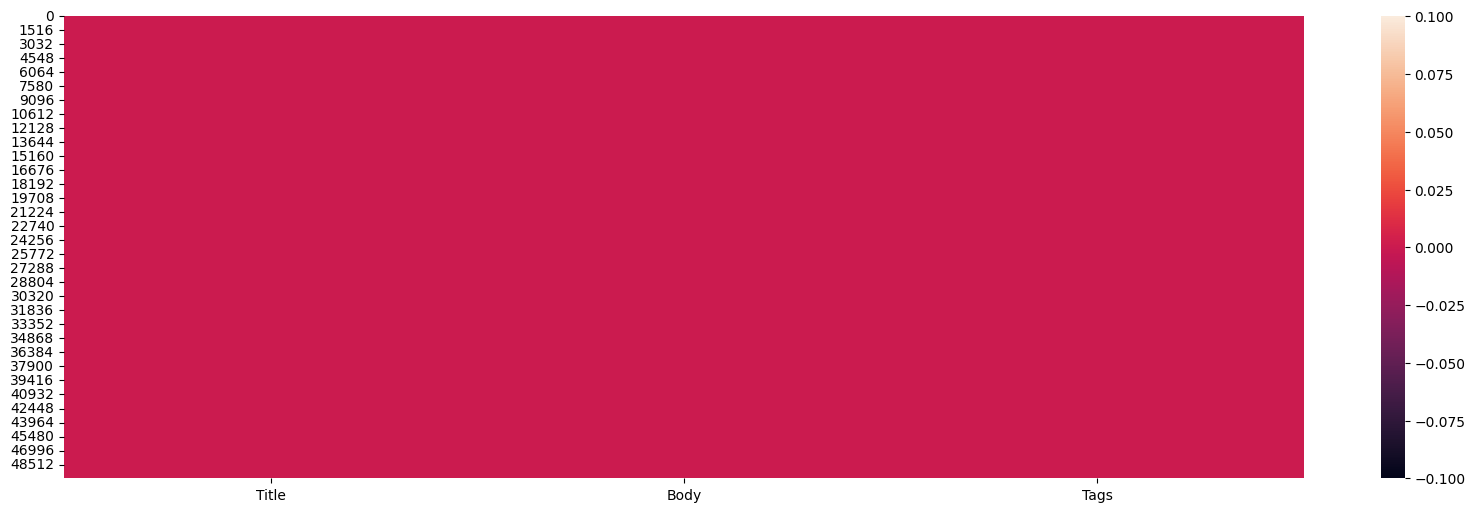

In [20]:
# Visualisation des valeurs manquantes.
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.heatmap(df.isna())

In [21]:
# Nombre de doublons pour une ligne entière de données.
df.duplicated().sum()

0

In [22]:
# Nombre de valeurs uniques par colonnes.
df.nunique()


Title    50000
Body     50000
Tags     48067
dtype: int64

In [23]:
# Nombre de doublons par colonnes.
for col in df.columns:
    n = df.duplicated(subset=col).sum()
    print(f"{col} : {n}")

Title : 0
Body : 0
Tags : 1933


<a name="C4"><font color='chocolate'>**Respect du RGPD.**</font></a>

[source : cnil](https://www.cnil.fr/fr/cnil-direct/question/quels-sont-les-grands-principes-des-regles-de-protection-des-donnees)

Description et application des 5 grands principes du Règlement Général sur la Protection des Données (RGPD) dans ce projet

- <span style="text-decoration: underline;">Le principe de finalité</span> : *le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime.*
 
  =>  Les données collectées sont utilisée exclusivement dans le cadre de la création d'un algorithme de machine learning qui permet d'assigner automatiquement plusieurs tags pertinents à une question. Les données ne sont pas déstinées à quelconques autres usages.

- <span style="text-decoration: underline;">Le principe de proportionnalité et de pertinence</span> : *les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier.*
  
  => On utilise des filtres sur les données de la requête pour ne récupérer que les variables essentielles au projet. On évite également de récupérer des information non necessaire qui permettrait d'identifier un individu.

- <span style="text-decoration: underline;">Le principe d'une durée de conservation limitée</span> : *il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier.*

  => Les données ne contiennent pas d'information permettant l'identification de personnes, cependant, si c'était le cas il serait necessaire de fixer une date maximale de suppression des données en accord avec les contraintes légales ou d'anonymiser les données si elles doivent être conservées plus longtemps.

- <span style="text-decoration: underline;">Le principe de sécurité et de confidentialité</span> : *le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations.*

  => Içi on ne récupère pas de <font color = 'grey'>données à caractère personnel*</font>, si ça avait été le cas, il serait necessaire d'utiliser des données fictives ou d'anonymiser les données permettant d'identifier un individu.

- <span style="text-decoration: underline;">Les droits des personnes</span> : *Le propriétaire des données doit avoir donné son accord pour que ses données personnelles soient collectées et utilisées légalement.*

  => On s'assure que les utilisateurs aient accepté que leurs données personnelles soient collectées (par StackOverflow) grâce à l'onglet [Privacy Policy](https://stackoverflow.com/legal/privacy-policy). Içi on comprends que pour créer un compte utilisateurs, il faut accpéter les conditions de collecte des données par stackoverflow.

*<font color = 'grey'>*Toute information relative à une personne physique susceptible d'être identifiée, directement ou indirectement.</font>*

## <a name="C5"><font color='navy'>Nettoyage des données texte</a></font>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C6">Détection du langage.</a>
- <a href="#C7">Pré-traitement des données texte.</a>
- <a href="#C8">Création du vocabulaire.</a>

<a name="C6"><font color='chocolate'>**Détection du langage.**</font></a>

Dans un premier temps, comme on utilise des données sous forme de chaîne de caractères, je souhaite détecter le ou les langages utilisés dans la base de données. En fonction de la répartition des langages utilisés et si le langage le plus utilisé me permet d'avoir une volumétrie de donnée significative pour la suite de l'étude, je ne conserverais que les données du langage le plus utilisé par les internautes.

In [30]:
###################### A supprimer avant de tout relancer quand ok sur nettoyage jeu de données #####################
# Utilisation d'un échantillon pour tests plus rapides.
# df = df.sample(frac=0.1)

In [31]:
# Application de la fonction pour détecter la langue utilisée.
message, language_counts, most_common_language, rate = detect_language_and_analyze(df, 'Body')

# Affichage du résultat.
# print(message)

[10/27/24 08:40:19] INFO     La langue la plus utilisée est 'en' (anglais) avec un    preprocessing_fonctions.py:90
                             taux d'utilisation de 99.18%.                                                         
                             Nombre de lignes en 'en': 49589 sur 50000 lignes                                      
                             totales.                                                                              

On défini un seuil acceptable de représentation "top_langage" en fonction duquel on supprimera les lignes qui ne correspondent pas à "top_langage". Ce paramétrage du seuil est fixé dans le fichier data_preprocessing_config. Si la condition de respect de seuil n'est pas respectée, on ne supprime pas les lignes "autre langage".

In [33]:
# Fonction de supression des lignes "langages differents de langue majoritaire".
df = filter_top_language(df, seuil_representation_top_langage, rate, most_common_language)

                    INFO     Seuil défini pour le filtrage : 75.00%                  preprocessing_fonctions.py:117

                    INFO     Taux top langage suffisant pour créer un filtre afin de preprocessing_fonctions.py:134
                             ne conserver que les top langages.                                                    

In [34]:
df.shape

(49589, 4)

In [35]:
# Suppression de la colonne "language".
df = df.drop(columns=['language'])
df.head()

,Title,Body,Tags
0,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...
1,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...
2,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>
3,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...
4,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>


In [36]:
# Enregistrement des données nettoyées dans le fichier.
df.to_json('df_en_words.json', orient='records', lines=True)

<a name="C7"><font color='chocolate'>**Pré-traitement des données texte.**</font></a>

Ensuite, nous allons supprimer les caractères spéciaux, corriger les contractions de mots, séparer les phrases en unités de mots (Tokenisation) puis éliminer que les mots qui n'apportent pas d'informations (stopwords).

Quelques définitions :

***La tokenisation** est le processus de division d'un texte en unités plus petites appelées "tokens". Ces unités peuvent être des mots, des phrases ou même des caractères individuels. En traitement du langage naturel (NLP), la tokenisation est une étape essentielle qui permet de préparer le texte brut pour une analyse ultérieure, telle que la modélisation statistique ou l'apprentissage automatique.*

***Les Stopwords** sont des mots courants dans une langue qui sont souvent filtrés avant ou après le traitement des données textuelles. Ils sont généralement considérés comme ayant peu de valeur ajoutée pour les tâches de traitement du langage naturel (NLP), car ils n'apportent pas beaucoup d'information significative par rapport au contenu du texte.*

Enfin, l'idée est de créer le vocabulaire : 
Quelques définitions :

***Le vocabulaire** : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus.*

***La lemmatisation** permet de regrouper différentes formes d'un mot sous une seule forme canonique, ce qui facilite l'analyse et le traitement des données textuelles. L'idée est d'utiliser des règles linguistiques et des dictionnaires pour transformer les mots en leur forme canonique correcte, en tenant compte du contexte grammatical (par exemple, "better" devient "good" et "running" devient "run").*

***Le stemming** consiste à couper les suffixes des mots pour obtenir la racine (par exemple, "running" devient "run").*

***POS Tagging (Part-of-Speech Tagging)** : représente les méthodes qui récupèrent la nature grammatical des mots d’une phrase - nom, verbe, adjectif, etc. Ce sont des propriété qui peuvent servir de caractéristiques utile lors de la création de certains modèles.*

***NER (Named Entity Recognition)** : reconnaître des personnes, endroits, entreprises, etc.*

On utilisera içi la lemmatisation, cette méthode est plus facile à interpréter que stemming car on utilise la forme canonique des mots donc on ne les sort pas de leur contexte (tandis que stemming supprime les suffixe ce qui rend plus compliqué l'interprétation des mots en sortie).

In [39]:
# Import des données.
df_en_w = pd.read_json('df_en_words.json', orient='records', lines=True)
df_en_w.head()

,Title,Body,Tags
0,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...
1,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...
2,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>
3,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...
4,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>


**Variable Tags.**

In [41]:
# Application des fonctions de pré-traitement des tags.
df_en_w = preprocess_tags(df_en_w, column_name='Tags', top_N=top_N, min_occurrences=min_occurrences)

# Affiche les premières lignes de tags nettoyés.
df_en_w.head()

[10/27/24 08:40:25] INFO     Prétraitement de la colonne 'Tags' terminé avec succès. preprocessing_fonctions.py:196

,Title,Body,Tags,Tags_cleaned
0,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...,"[machine-learning, pytorch, tensorflow, deep-l..."
1,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...,[django]
2,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>,"[html, javascript, ios]"
3,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...,"[react-native, javascript]"
4,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>,"[reactjs, javascript, webpack]"


**Analyse des POS (part-of-speech) Tagging les plus fréquents dans les Tags.**

In [43]:
# Conversion des colonnes contenant des listes en texte.
columns_to_convert = ['Tags_cleaned']
df_en_w = convert_lists_to_text(df_en_w, columns_to_convert)

In [44]:
# Application de la fonction de POS Tagging.
df_en_w['pos_tagging_tags'] = df_en_w['Tags_cleaned'].apply(pos_tagging_fct)

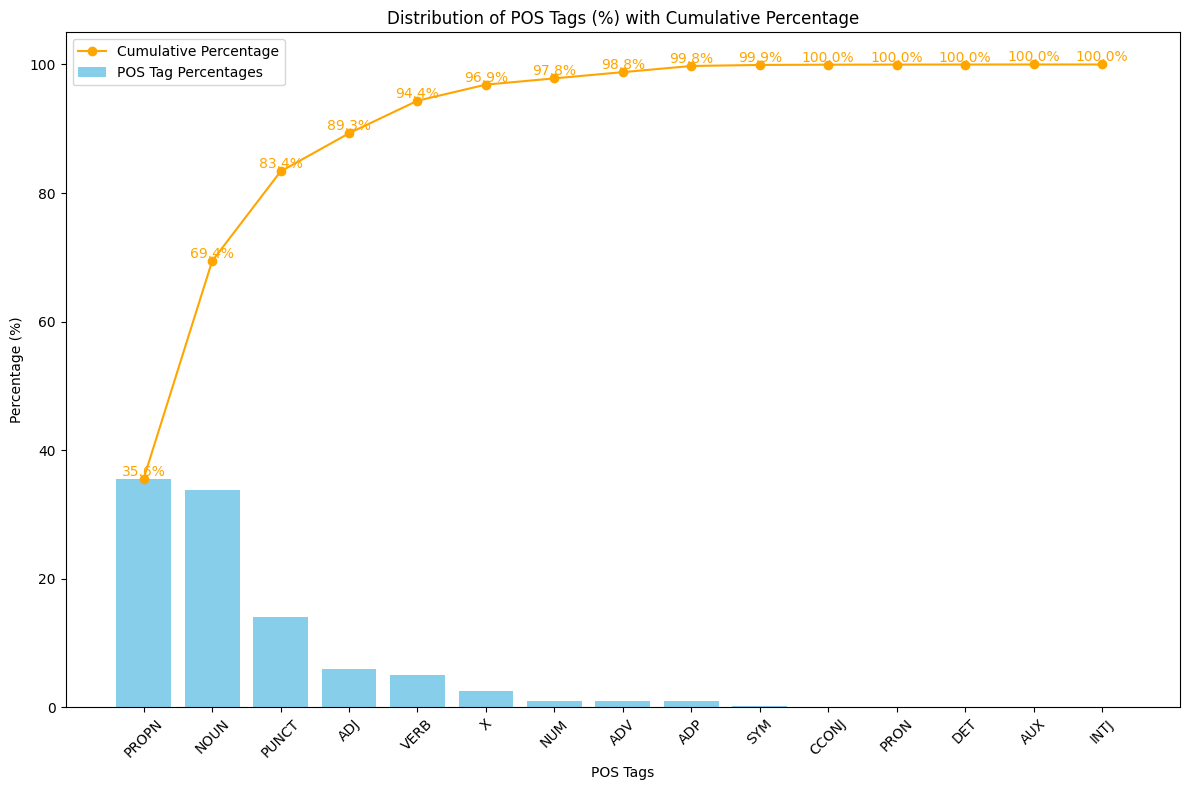

In [45]:
# Répartition des POS Tagging pour les tags.
# Extraction de toutes les étiquettes POS.
all_pos_tags = [pos for sublist in df_en_w['pos_tagging_tags'] for word, pos in sublist]

# Calcul de la fréquence des étiquettes POS.
pos_tag_counts = Counter(all_pos_tags)

# Tri par ordre décroissant de fréquence.
pos_tag_counts_sorted = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Calcul du total des étiquettes POS.
total_pos_tags = sum(pos_tag_counts_sorted.values())

# Calcul des pourcentages pour chaque POS.
pos_tag_percentages = {pos: (count / total_pos_tags) * 100 for pos, count in pos_tag_counts_sorted.items()}

# Conversion en deux listes pour le graphique : étiquettes POS et leurs pourcentages.
labels, percentages = zip(*pos_tag_percentages.items())

# Calcul du pourcentage cumulé.
cumulative_percentages = np.cumsum(percentages)

# Création du graphique en barres.
plt.figure(figsize=(12, 8))

# Trace les barres.
plt.bar(labels, percentages, color='skyblue', label='POS Tag Percentages')

# Trace la courbe de pourcentage cumulé.
plt.plot(labels, cumulative_percentages, color='orange', marker='o', linestyle='-', label='Cumulative Percentage')

# Ajout des pourcentages cumulés au-dessus de chaque point sur la courbe.
for i, txt in enumerate(cumulative_percentages):
    plt.text(labels[i], cumulative_percentages[i], f'{txt:.1f}%', 
             color='orange', ha='center', va='bottom', fontsize=10)

# Ajout des légendes et titres.
plt.xlabel('POS Tags')
plt.ylabel('Percentage (%)')
plt.title('Distribution of POS Tags (%) with Cumulative Percentage')
plt.xticks(rotation=45)

# Affichage de la légende.
plt.legend()

# Affichage du graphique.
plt.tight_layout()
plt.show()

Plus de 50% des tags nettoyés correspondent à des noms et des pronoms.

In [47]:
# Conversion des colonnes contenant des texte en listes.
columns_to_convert = ['Tags_cleaned']
df_en_w = convert_text_to_lists(df_en_w, columns_to_convert)

In [48]:
# Compte la fréquence de chaque tags.
tag_counts = Counter([tag for tags in df_en_w['Tags_cleaned'] for tag in tags])

# Récupération des 20 tags les plus fréquents.
top_N = 20
most_common_tags = tag_counts.most_common(top_N)

# Séparation des tags et leur fréquence.
tags, counts = zip(*most_common_tags)

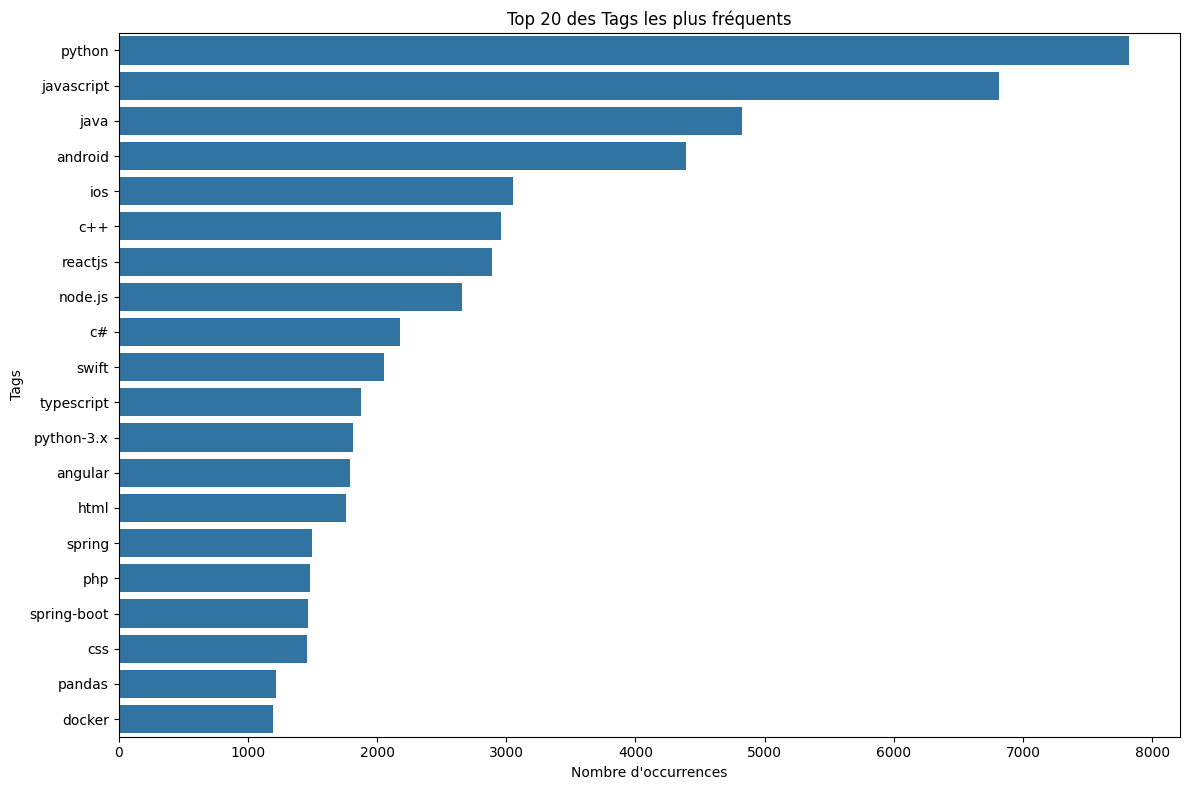

In [49]:
# Visualisation.
plt.figure(figsize=(12, 8))

# Création du barplot des tags les plus fréquents.
sns.barplot(x=list(counts), y=list(tags))

# Ajout des labels.
plt.title('Top 20 des Tags les plus fréquents')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Tags')

# Affichage du graphique.
plt.tight_layout()
plt.show()

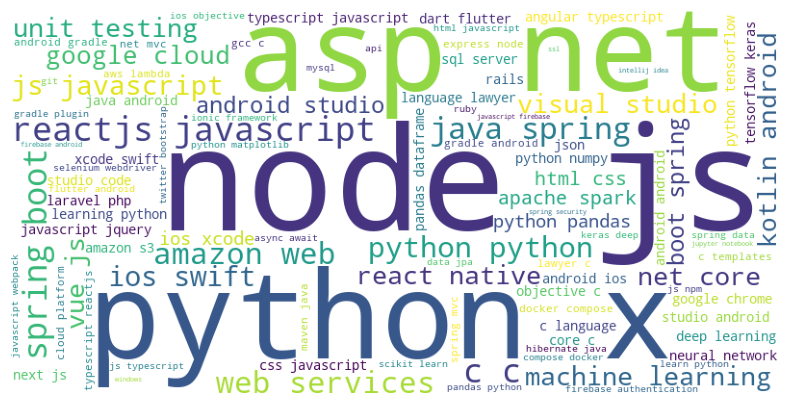

In [50]:
# Création d'une chaîne de texte avec tous les tags répétés selon leur fréquence.
tags_text = ' '.join([tag for tags in df_en_w['Tags_cleaned'] for tag in tags])

# Création du wordcloud.
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white',
                      max_words=100).generate(tags_text)

# Affichage du WordCloud.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [51]:
# Vérification de la complétude des données.
df_en_w.isna().mean()


Title               0.0
Body                0.0
Tags                0.0
Tags_cleaned        0.0
pos_tagging_tags    0.0
dtype: float64

In [52]:
# Filtre les lignes avec 'Tags_cleaned' est une liste vide.
df_en_w = df_en_w[df_en_w['Tags_cleaned'].apply(lambda x: len(x) > 0)]

# Vérification du résultat.
df_en_w.head()

,Title,Body,Tags,Tags_cleaned,pos_tagging_tags
0,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...,"[machine-learning, pytorch, tensorflow, deep-l...","[(machine, NOUN), (-, PUNCT), (learning, VERB)..."
1,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...,[django],"[(django, PROPN)]"
2,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>,"[html, javascript, ios]","[(html, PROPN), (javascript, VERB), (ios, NOUN)]"
3,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...,"[react-native, javascript]","[(react, VERB), (-, PUNCT), (native, ADJ), (ja..."
4,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>,"[reactjs, javascript, webpack]","[(reactjs, PROPN), (javascript, PROPN), (webpa..."


In [53]:
# Dimension des données.
df_en_w.shape

(48155, 5)

**Variables Title et Body.**

Dans un premier temps nous allons regrouper les colonnes Title et Body pour les traiter ensemble et appliquer les mêmes étapes de nettoyage.

In [56]:
# Regroupement des colonnes 'Title' et 'Body' en une nouvelle colonne 'text'.
df_en_w = df_en_w.copy()
df_en_w['text'] = df_en_w['Title'] + ' ' + df_en_w['Body']

In [57]:
# Supression des balises HTML.
df_en_w['text'] = df_en_w['text'].apply(clean_html)

In [58]:
# Sélection des colonnes utiles.
df = df_en_w[['text', 'Tags_cleaned']]

In [59]:
# Conversion des colonnes contenant des listes en texte.
df = df.copy()
columns_to_convert = ['text']
corpus_text_init = convert_lists_to_text(df, columns_to_convert)
corpus_text_init.head()

,text,Tags_cleaned
0,What is the best way to handle the background ...,"[machine-learning, pytorch, tensorflow, deep-l..."
1,How can I serve my django website from multipl...,[django]
2,Does HTML's 'onclick' work on mobile devices? ...,"[html, javascript, ios]"
3,How to center an image in React Native Backgro...,"[react-native, javascript]"
4,Module not found: Can't resolve 'style' I am t...,"[reactjs, javascript, webpack]"


In [60]:
df['sentence_bow_lem'] = df['text'].apply(lambda x: transform_bow_lem_fct(x))

In [61]:
df['sentence_bow'] = df['text'].apply(lambda x: transform_bow_fct(x))

In [62]:
df['sentence_dl'] = df['text'].apply(lambda x: transform_dl_fct(x))
df.head()

,text,Tags_cleaned,sentence_bow_lem,sentence_bow,sentence_dl
0,What is the best way to handle the background ...,"[machine-learning, pytorch, tensorflow, deep-l...",best way handle background pixel class trainin...,best way handle background pixel classes train...,what is the best way to handle the background ...
1,How can I serve my django website from multipl...,[django],serve django website multiple machine make dis...,serve django website multiple machines make di...,how can i serve my django website from multipl...
2,Does HTML's 'onclick' work on mobile devices? ...,"[html, javascript, ios]",html work mobile device html onclick attribute...,html work mobile devices html onclick attribut...,does html work on mobile devices does the html...
3,How to center an image in React Native Backgro...,"[react-native, javascript]",center image react native background image mea...,center image react native background image mea...,how to center an image in react native backgro...
4,Module not found: Can't resolve 'style' I am t...,"[reactjs, javascript, webpack]",module found ca resolve trying configure cs mo...,module found ca resolve trying configure css m...,module not found can not resolve i am trying t...


In [63]:
# Compte les mots pour la variable 'text'.
total_text, distinct_text = count_words(df['text'])

# Compte les mots pour la variable 'sentence_bow_lem'.
total_bow_lem, distinct_bow_lem = count_words(df['sentence_bow_lem'])

# Affichage des résultats.
print(f"Nombre total de mots dans 'text' : {total_text}")
print(f"Nombre de mots distincts dans 'text' : {distinct_text}")
print(f"Nombre total de mots dans 'sentence_bow_lem' : {total_bow_lem}")
print(f"Nombre de mots distincts dans 'sentence_bow_lem' : {distinct_bow_lem}")

# Comparaison des résultats.
print(f"Différence (total de mots) : {total_bow_lem - total_text}")
print(f"Différence (mots distincts) : {distinct_bow_lem - distinct_text}")

Nombre total de mots dans 'text' : 16312646
Nombre de mots distincts dans 'text' : 733936
Nombre total de mots dans 'sentence_bow_lem' : 5312915
Nombre de mots distincts dans 'sentence_bow_lem' : 139225
Différence (total de mots) : -10999731
Différence (mots distincts) : -594711


On a réduit considérablement le nombre de tokens.

In [65]:
# Application de la fonction de POS Tagging pour la variable 'sentence_bow_lem'.
df = df.copy()
df.loc[:, 'pos_tagging_sentence_bow_lem'] = df['sentence_bow_lem'].apply(pos_tagging_fct)

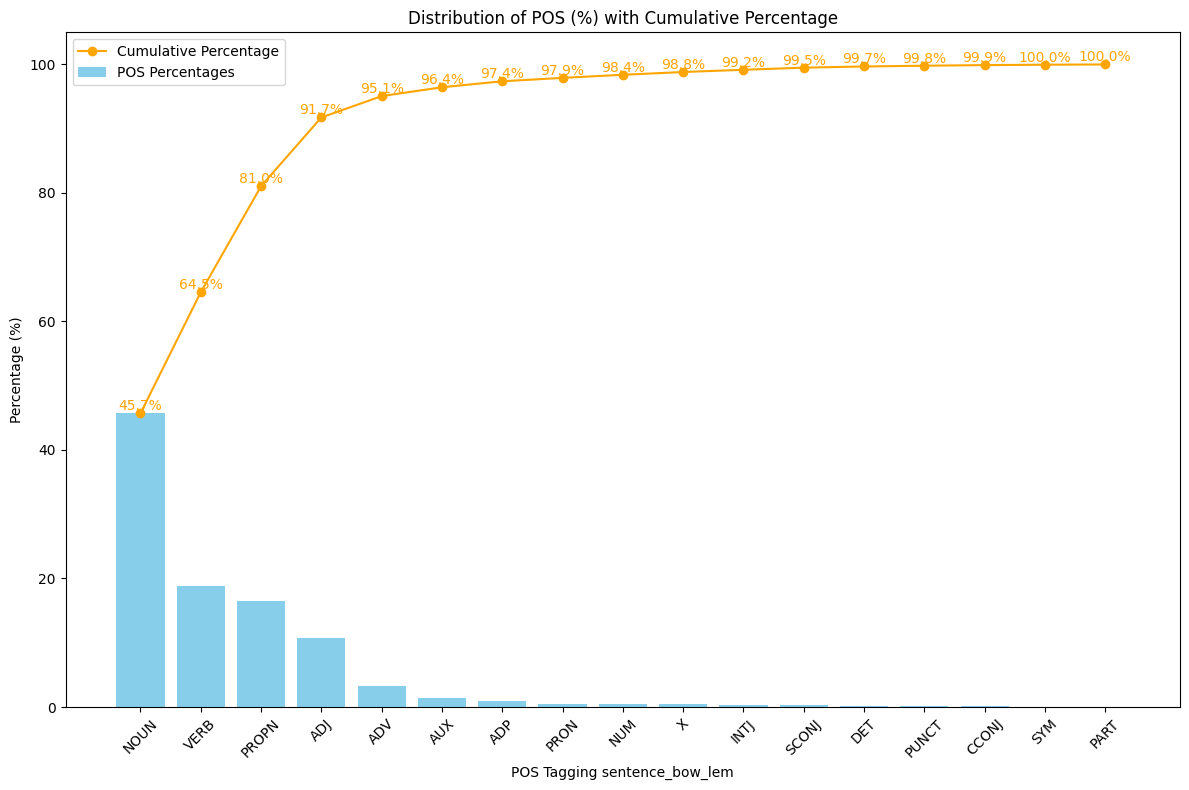

In [66]:
# Répartition des POS Tagging pour 'sentence_bow_lem'.
# Extraction de toutes les étiquettes POS.
all_pos_tags = [pos for sublist in df['pos_tagging_sentence_bow_lem'] for word, pos in sublist]

# Calcul de la fréquence des étiquettes POS.
pos_tag_counts = Counter(all_pos_tags)

# Tri par ordre décroissant de fréquence.
pos_tag_counts_sorted = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Calcul du total des étiquettes POS.
total_pos_tags = sum(pos_tag_counts_sorted.values())

# Calcul des pourcentages pour chaque POS.
pos_tag_percentages = {pos: (count / total_pos_tags) * 100 for pos, count in pos_tag_counts_sorted.items()}

# Conversion en deux listes pour le graphique : étiquettes POS et leurs pourcentages.
labels, percentages = zip(*pos_tag_percentages.items())

# Calcul du pourcentage cumulé.
cumulative_percentages = np.cumsum(percentages)

# Création du graphique en barres.
plt.figure(figsize=(12, 8))

# Trace les barres.
plt.bar(labels, percentages, color='skyblue', label='POS Percentages')

# Trace la courbe de pourcentage cumulé.
plt.plot(labels, cumulative_percentages, color='orange', marker='o', linestyle='-', label='Cumulative Percentage')

# Ajout des pourcentages cumulés au-dessus de chaque point sur la courbe.
for i, txt in enumerate(cumulative_percentages):
    plt.text(labels[i], cumulative_percentages[i], f'{txt:.1f}%', 
             color='orange', ha='center', va='bottom', fontsize=10)

# Ajout des légendes et titres.
plt.xlabel('POS Tagging sentence_bow_lem')
plt.ylabel('Percentage (%)')
plt.title('Distribution of POS (%) with Cumulative Percentage')
plt.xticks(rotation=45)

# Affichage de la légende.
plt.legend()

# Affichage du graphique.
plt.tight_layout()
plt.show()

In [67]:
# Calcul des fréquences de mots dans 'sentence_bow_lem_pos'
word_frequencies_sentence_bow_lem = get_word_frequencies(df['sentence_bow_lem'])

# Affichage des 100 mots les plus fréquents.
print(word_frequencies_sentence_bow_lem.most_common(100))

[('error', 44960), ('using', 42205), ('file', 41414), ('return', 33506), ('import', 31954), ('code', 31445), ('new', 28822), ('get', 28250), ('use', 27099), ('function', 26833), ('class', 26800), ('http', 25275), ('like', 25181), ('data', 24289), ('string', 24280), ('public', 22298), ('app', 21733), ('work', 21189), ('android', 19775), ('value', 19741), ('name', 18883), ('type', 18772), ('true', 18364), ('user', 18279), ('test', 17951), ('run', 17613), ('const', 17401), ('c', 17012), ('int', 16690), ('would', 16559), ('want', 16431), ('version', 16326), ('line', 15773), ('following', 15533), ('one', 15514), ('way', 15273), ('set', 14619), ('x', 14148), ('tried', 13938), ('problem', 13914), ('method', 13719), ('var', 13386), ('need', 13025), ('trying', 12972), ('time', 12970), ('also', 12885), ('id', 12832), ('object', 12710), ('project', 12585), ('image', 12357), ('example', 12106), ('request', 11990), ('void', 11779), ('result', 11650), ('server', 11622), ('std', 11448), ('build', 114

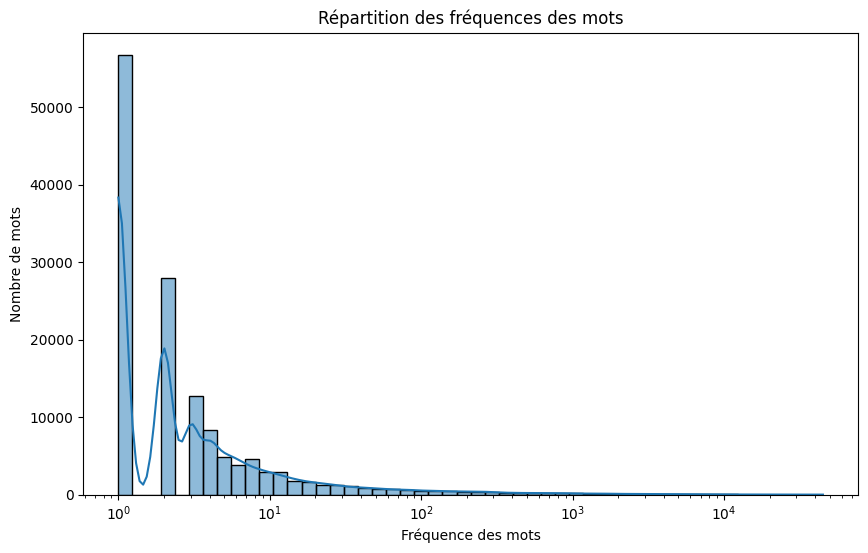

In [68]:
# Récupération des fréquences des mots.
frequencies = list(word_frequencies_sentence_bow_lem.values())

# Création de l'histogramme de la distribution des fréquences.
plt.figure(figsize=(10, 6))

# Utilisation de l'échelle logarithmique pour mieux visualiser la distribution.
sns.histplot(frequencies, bins=50, kde=True, log_scale=(True, False))

# Ajout des labels et du titre.
plt.title('Répartition des fréquences des mots')
plt.xlabel('Fréquence des mots')
plt.ylabel('Nombre de mots')

# Affichage du graphique.
plt.show()

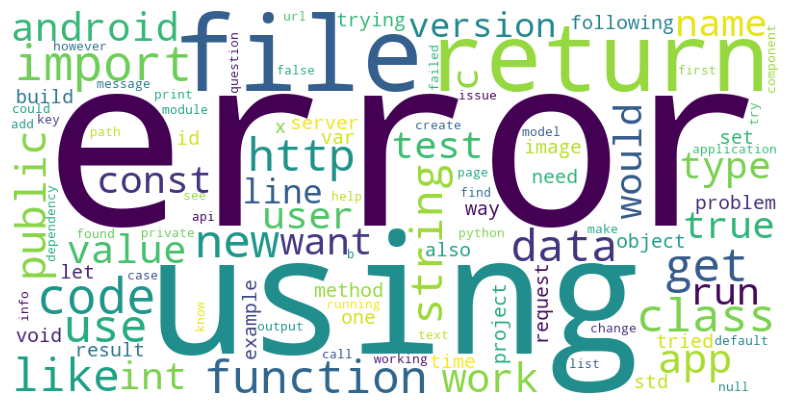

In [69]:
# Visualisation des mots de la variable sentence_bow_lem_pos dans un wordCloud.
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white',
                      max_words=100).generate_from_frequencies(dict(word_frequencies_sentence_bow_lem))

# Affichage du WordCloud.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [70]:
# Affichage des 20 mots les moins fréquents.
least_common_words = sorted(word_frequencies_sentence_bow_lem.items(), key=lambda x: x[1])[:200]

print(least_common_words)

[('safiri', 1), ('requireensure', 1), ('pumactl', 1), ('xyneex', 1), ('karwasz', 1), ('gettokenbalances', 1), ('getsupportedchains', 1), ('mapusers', 1), ('userarn', 1), ('argumentsfor', 1), ('nominate', 1), ('depacks', 1), ('deplyment', 1), ('saloo', 1), ('stackbliz', 1), ('savevalue', 1), ('savevalueaction', 1), ('stackfield', 1), ('heapfield', 1), ('afield', 1), ('č', 1), ('š', 1), ('ľ', 1), ('ĺ', 1), ('rtsps', 1), ('rtspsh', 1), ('editactionsforrowat', 1), ('posusertabelcell', 1), ('glgenrenderbuffers', 1), ('glbindrenderbuffer', 1), ('glrenderbufferstorage', 1), ('glgenframebuffers', 1), ('glbindframebuffer', 1), ('glframebufferrenderbuffer', 1), ('glreadbuffer', 1), ('glbitfield', 1), ('releasedata', 1), ('bitsperpixel', 1), ('imaag', 1), ('caeaglview', 1), ('caeglview', 1), ('leet', 1), ('racecar', 1), ('httpheaderconfig', 1), ('httpheadername', 1), ('simultanious', 1), ('mlines', 1), ('setsvgicnforbtnfnc', 1), ('setbtnvar', 1), ('porterduffcolorfilter', 1), ('tit', 1), ('rit', 

In [71]:
# Conversion des colonnes contenant des texte en listes.
columns_to_convert = ['sentence_bow_lem']
df = convert_lists_to_text(df, columns_to_convert)

In [72]:
# Affichage du nombre des mots par intervalle de fréquences.
list_max_1_words = [word for word, freq in word_frequencies_sentence_bow_lem.items() if 1 <= freq]

# Affichage des résultats.
print(f"Nombre de mots présents une seule fois : {len(list_max_1_words)}")

Nombre de mots présents une seule fois : 139225


In [73]:
# Echantillon de mots présents une seule fois.
random_list_max_1_words = random.sample(list_max_1_words, 50)
print(random_list_max_1_words)

['kubeletconfiguration', 'dequeuereusablecellwithreuseidentifier', 'slideprev', 'servicenotification', 'retrystrategy', 'nameofdialog', 'firefox', 'nomeresponsavel', 'suboptions', 'kuberenetes', 'srcrect', 'visua', 'craete', 'preferencetheme', 'getactivitylifecycle', 'pdname', 'valuated', 'webfilter', 'testcontrollergetall', 'nocreaterole', 'appenders', 'storestate', 'mdeviceinterface', 'precalculated', 'reactivate', 'lurker', 'moby', 'mikepenz', 'ldif', 'greenbutton', 'selectionargs', 'maxttl', 'multipleselectionandvirtualspace', 'datasourcebean', 'unpickling', 'imgurl', 'carservice', 'sorthandlermethodargumentresolver', 'mfqpmlkxetezcvcl', 'xsi', 'ophighce', 'oov', 'loggerinterceptor', 'isnotemptyarray', 'vertical', 'keywordswillbestored', 'massey', 'contacthistory', 'andrii', 'smartstep']


In [74]:
# On souhaite que 'sentence_bow_lem' contienne bien des listes de mots.
df['sentence_bow_lem'] = df['sentence_bow_lem'].apply(lambda x: x if isinstance(x, list) else x.split())

In [75]:
#from collections import Counter

# Calcul des fréquences de tous les mots dans 'sentence_bow_lem'
#word_frequencies_sentence_bow_lem = Counter([word for sentence in df['sentence_bow_lem'] for word in sentence])

In [76]:
# Supression des mots unique.
df['sentence_bow_lem'] = df['sentence_bow_lem'].apply(
    lambda words: remove_unique_words(words, word_frequencies_sentence_bow_lem)
)

# Vérification des résultats.
df.head()

,text,Tags_cleaned,sentence_bow_lem,sentence_bow,sentence_dl,pos_tagging_sentence_bow_lem
0,What is the best way to handle the background ...,"[machine-learning, pytorch, tensorflow, deep-l...","[best, way, handle, background, pixel, class, ...",best way handle background pixel classes train...,what is the best way to handle the background ...,"[(best, ADJ), (way, NOUN), (handle, VERB), (ba..."
1,How can I serve my django website from multipl...,[django],"[serve, django, website, multiple, machine, ma...",serve django website multiple machines make di...,how can i serve my django website from multipl...,"[(serve, VERB), (django, PROPN), (website, NOU..."
2,Does HTML's 'onclick' work on mobile devices? ...,"[html, javascript, ios]","[html, work, mobile, device, html, onclick, at...",html work mobile devices html onclick attribut...,does html work on mobile devices does the html...,"[(html, PROPN), (work, VERB), (mobile, ADJ), (..."
3,How to center an image in React Native Backgro...,"[react-native, javascript]","[center, image, react, native, background, ima...",center image react native background image mea...,how to center an image in react native backgro...,"[(center, NOUN), (image, NOUN), (react, VERB),..."
4,Module not found: Can't resolve 'style' I am t...,"[reactjs, javascript, webpack]","[module, found, ca, resolve, trying, configure...",module found ca resolve trying configure css m...,module not found can not resolve i am trying t...,"[(module, NOUN), (found, VERB), (ca, AUX), (re..."


In [77]:
columns_to_convert = ['sentence_bow_lem']
corpus_text_init = convert_lists_to_text(df, columns_to_convert)

# Compte les mots pour la variable 'sentence_bow_lem'.
total_bow_lem, distinct_bow_lem = count_words(df['sentence_bow_lem'])

# Affichage des résultats.
print(f"Nombre total de mots dans 'sentence_bow_lem' : {total_bow_lem}")
print(f"Nombre de mots distincts dans 'sentence_bow_lem' : {distinct_bow_lem}")

Nombre total de mots dans 'sentence_bow_lem' : 5256113
Nombre de mots distincts dans 'sentence_bow_lem' : 82423


In [78]:
# Calcul des fréquences de mots dans 'sentence_bow_lem'
word_frequencies_sentence_bow_lem = get_word_frequencies(df['sentence_bow_lem'])

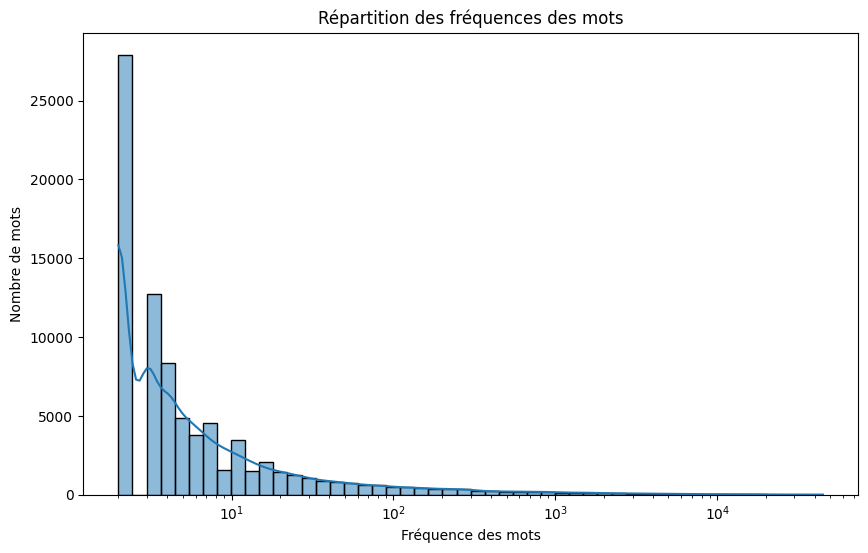

In [79]:
# Récupération des fréquences des mots.
frequencies = list(word_frequencies_sentence_bow_lem.values())

# Création de l'histogramme de la distribution des fréquences.
plt.figure(figsize=(10, 6))

# Utilisation de l'échelle logarithmique pour mieux visualiser la distribution.
sns.histplot(frequencies, bins=50, kde=True, log_scale=(True, False))

# Ajout des labels et du titre.
plt.title('Répartition des fréquences des mots')
plt.xlabel('Fréquence des mots')
plt.ylabel('Nombre de mots')

# Affichage du graphique.
plt.show()

On passe de 140 000 mots distincts à 82 500 mots distincts en supprimants les mots uniques.

In [81]:
# On renomme une variable.
df = df.rename(columns={'Tags_cleaned': 'tags_cleaned'})

# Enregistrement des colonnes necessaires.
filtered_df = df[['text', 'tags_cleaned', 'sentence_bow_lem', 'sentence_bow', 'sentence_dl']]

In [82]:
# Remplacer les non-strings par des chaînes vides
df['sentence_bow_lem'] = df['sentence_bow_lem'].apply(lambda x: x if isinstance(x, str) else '')

In [83]:
# Remplacer les NaN par des chaînes vides ou supprimer les lignes avec des NaN
df['sentence_bow_lem'] = df['sentence_bow_lem'].fillna('')  # Remplace NaN par des chaînes vides

In [84]:
# Appliquer la tokenisation
df['sentence_bow_lem'] = df['sentence_bow_lem'].apply(nltk.word_tokenize)
data_lemmatized = df['sentence_bow_lem'].tolist()

# Vérifier les 5 premières entrées après tokenisation.
print(data_lemmatized[:5])

[['best', 'way', 'handle', 'background', 'pixel', 'class', 'training', 'deep', 'learning', 'model', 'semantic', 'segmentation', 'trying', 'train', 'unet', 'model', 'cityscape', 'dataset', 'semantic', 'class', 'bunch', 'background', 'class', 'ignored', 'ex', 'sky', 'ego', 'vehicle', 'mountain', 'street', 'light', 'train', 'model', 'ignore', 'background', 'pixel', 'using', 'following', 'popular', 'solution', 'internet', 'assign', 'common', 'ex', 'pixel', 'belonging', 'ignore', 'class', 'train', 'model', 'using', 'loss', 'pixel', 'prediction', 'provide', 'parameter', 'loss', 'therefore', 'loss', 'computed', 'ignores', 'pixel', 'unnecessary', 'class', 'approach', 'problem', 'trained', 'model', 'end', 'classifying', 'background', 'pixel', 'belonging', 'one', 'class', 'instead', 'expected', 'loss', 'penalize', 'model', 'whatever', 'classification', 'make', 'background', 'pixel', 'second', 'obvious', 'solution', 'therefore', 'use', 'extra', 'class', 'background', 'pixel', 'therefore', 'class'

In [85]:
# Remplacer les caractères Unicode non valides dans les chaînes de texte avant de les enregistrer.
filtered_df = filtered_df.applymap(lambda x: x.encode('utf-8', 'surrogatepass').decode('utf-8', 'ignore') if isinstance(x, str) else x)

# Enregistrement des données nettoyées dans le fichier.
filtered_df.to_json('cleaned_df_final.json', orient='records', lines=True, force_ascii=False)

In [86]:
# Vérification de la complétude des données.
filtered_df.isna().mean()


text                0.0
tags_cleaned        0.0
sentence_bow_lem    0.0
sentence_bow        0.0
sentence_dl         0.0
dtype: float64

On utilisera differentes techniques pour le nettoyage des données texte en fonction de la manière dont les textes seront utilisés dans le modèle. 

**BoW et TF-IDF** : Ces méthodes sont basées sur des représentations discrètes de mots (comptes de mots), donc le nettoyage du texte (suppression des stop words, lemmatisation) est crucial pour réduire le bruit et concentrer l'information sur les mots les plus significatifs.

**Word2Vec** : Similaire à BoW et TF-IDF, mais il génère des embeddings vectoriels pour les mots. Cependant, conserver la forme originale des mots peut parfois être avantageux pour capturer des nuances sémantiques spécifiques.

**Modèles Deep Learning (USE, BERT)** : Ces modèles sont conçus pour comprendre le contexte et les relations sémantiques dans les phrases. Ils peuvent bénéficier d'un texte moins transformé, car les stop words et les formes originales des mots peuvent porter des informations contextuelles cruciales.

## <a name="C10"><font color='navy'>Vectorisation du texte</a></font>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C11">BoW et TF-IDF.</a>
- <a href="#C12">Word2Vec.</a>
- <a href="#C13">USE et BERT.</a>

*En traitement du langage naturel (NLP), transformer du texte en un format que les ordinateurs peuvent comprendre est crucial. Les ordinateurs travaillent avec des nombres, donc l'une des étapes essentielles du préprocessing de texte consiste à convertir les mots ou phrases en vecteurs numériques.*

**Les méthodes d’extraction de features qui seront utilisées dans ce notebook :**</font>


<font color =blue>**1. BoW (Bag of Words) : Compte la fréquence des mots dans un texte sans tenir compte de l'ordre des mots.**

- <span style="text-decoration: underline;">Principe :</span>

Le modèle Bag of Words est une méthode simple qui consiste à représenter un texte en fonction de la présence ou de la fréquence des mots. C'est comme faire l'inventaire de tous les mots d'un texte.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

BoW commence par créer un "vocabulaire", qui est une liste de tous les mots uniques dans l'ensemble du document.
Pour chaque phrase ou document, tu comptes combien de fois chaque mot de ton vocabulaire apparaît.
Le résultat du BoW donne une matrice de fréquence, où chaque ligne représente une question et chaque colonne représente un mot du vocabulaire. Les cellules contiennent le nombre d'occurrences du mot dans le document.

- <span style="text-decoration: underline;">Limitation :</span>

BoW ne tient pas compte de l'ordre des mots. Par exemple, les phrases "le chat mange une souris" et "une souris mange le chat" auront la même représentation, même si leur sens est différent.
Le vocabulaire peut devenir très grand, surtout avec des documents longs ou nombreux.



<font color =blue>**2. TF-IDF (Term Frequency-Inverse Document Frequency) : Pèse les mots en fonction de leur fréquence, en tenant compte de leur importance dans le corpus.**</font>

- <span style="text-decoration: underline;">Principe :</span>

TF-IDF est une méthode qui mesure non seulement la fréquence d'un mot dans un document (comme BoW), mais aussi son importance par rapport à l'ensemble des documents dans le corpus. Elle atténue l'impact des mots très courants comme "le", "et", etc., qui n'apportent pas beaucoup de sens.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

TF (Term Frequency) : C'est simplement le nombre de fois qu'un mot apparaît dans un document divisé par le nombre total de mots dans ce document.
IDF (Inverse Document Frequency) : C'est une mesure de la rareté d'un mot dans l'ensemble du corpus. Plus un mot est rare (apparaît dans peu de documents), plus sa valeur IDF est élevée.
TF-IDF est le produit des deux : TF-IDF = TF * IDF.

- <span style="text-decoration: underline;">Limitation :</span>

Comme BoW, TF-IDF ne prend pas en compte l'ordre des mots et ne capture pas le sens ou le contexte.



<font color =blue>**3. Word2Vec : Capture les relations sémantiques entre les mots en les représentant par des vecteurs denses.**</font>

- <span style="text-decoration: underline;">Principe :</span>

Word2Vec est une technique qui transforme les mots en vecteurs de manière à capturer les relations sémantiques entre eux. Autrement dit, elle essaie de placer les mots avec des significations similaires dans des espaces proches les uns des autres.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

Word2Vec repose sur deux architectures principales : CBOW (Continuous Bag of Words) et Skip-gram. CBOW prédit un mot à partir de son contexte (les mots autour).
Skip-gram prédit le contexte à partir d'un mot. En entraînant un modèle sur de grandes quantités de texte, chaque mot est représenté par un vecteur dense, où les mots similaires (comme "roi" et "reine") sont proches dans l'espace vectoriel.

- <span style="text-decoration: underline;">Avantage :</span>

Contrairement à BoW et TF-IDF, Word2Vec capture les relations sémantiques et contextuelles entre les mots.

- <span style="text-decoration: underline;">Limitation :</span>

Word2Vec traite les mots individuellement et n'est pas conçu pour capturer le contexte d'une phrase entière.



<font color =blue>**4. Universal Sentence Encoder (USE) : Encode des phrases entières en vecteurs pour capturer le sens global de la phrase.**</font>

- <span style="text-decoration: underline;">Principe :</span>

Le Universal Sentence Encoder est une méthode qui encode des phrases entières (plutôt que des mots individuels) en vecteurs. Ces vecteurs capturent le sens global de la phrase.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

USE est basé sur des modèles profonds (deep learning) qui sont pré-entraînés sur de grandes quantités de texte. Le modèle prend une phrase en entrée et produit un vecteur numérique de dimension fixe.
Ce vecteur peut ensuite être utilisé pour des tâches comme la similarité entre phrases, le regroupement de textes, ou même l'analyse de sentiment.

- <span style="text-decoration: underline;">Avantage :</span>

USE capture le contexte de toute une phrase, ce qui le rend plus adapté aux tâches où le sens global est important.

- <span style="text-decoration: underline;">Limitation :</span>

Bien que très efficace pour capturer le sens global, il peut parfois perdre des informations très spécifiques contenues dans des mots individuels.



<font color =blue>**5. BERT (Bidirectional Encoder Representations from Transformers) : Comprend le contexte bidirectionnel des mots dans une phrase, capturant ainsi les significations les plus nuancées.**</font>

- <span style="text-decoration: underline;">Principe :</span>

BERT est un modèle extrêmement puissant qui comprend le contexte de chaque mot dans une phrase en tenant compte des mots qui le précèdent et le suivent. C'est ce qu'on appelle un modèle bidirectionnel.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

BERT utilise une architecture appelée Transformers qui analyse le texte de manière bidirectionnelle. Il prend en compte les mots avant et après pour comprendre le contexte d'un mot particulier.
BERT peut être fine-tuné (ajusté) pour des tâches spécifiques comme la classification de texte, la réponse à des questions, etc.

- <span style="text-decoration: underline;">Avantage :</span>

Contrairement à Word2Vec ou même USE, BERT capture le contexte de manière bidirectionnelle, ce qui le rend particulièrement performant pour comprendre le sens nuancé des mots dans différents contextes.

- <span style="text-decoration: underline;">Limitation :</span>

BERT est très complexe et nécessite beaucoup de ressources informatiques pour l'entraînement et l'inférence. Il peut également être trop puissant pour des tâches simples où des techniques comme TF-IDF suffisent.

<a name="C11"><font color='chocolate'>**BoW et TF-IDF.**</font></a>

Le Bag of Words transforme les phrases en une matrice où chaque colonne représente un mot unique (vocabulaire), et chaque cellule contient la fréquence de ce mot dans chaque document.

In [3]:
# Import des données.
df = pd.read_json('cleaned_df_final.json', orient='records', lines=True)
df.head()

,text,tags_cleaned,sentence_bow_lem,sentence_bow,sentence_dl
0,What is the best way to handle the background ...,"[machine-learning, pytorch, tensorflow, deep-l...",best way handle background pixel class trainin...,best way handle background pixel classes train...,what is the best way to handle the background ...
1,How can I serve my django website from multipl...,[django],serve django website multiple machine make dis...,serve django website multiple machines make di...,how can i serve my django website from multipl...
2,Does HTML's 'onclick' work on mobile devices? ...,"[html, javascript, ios]",html work mobile device html onclick attribute...,html work mobile devices html onclick attribut...,does html work on mobile devices does the html...
3,How to center an image in React Native Backgro...,"[react-native, javascript]",center image react native background image mea...,center image react native background image mea...,how to center an image in react native backgro...
4,Module not found: Can't resolve 'style' I am t...,"[reactjs, javascript, webpack]",module found ca resolve trying configure cs mo...,module found ca resolve trying configure css m...,module not found can not resolve i am trying t...


In [29]:
# Affichage d'une ligne aléatoire du DataFrame
pd.set_option('display.max_colwidth', None)

# Affichage d'une ligne aléatoire du DataFrame
random_row = df.sample()
print(random_row)

**BoW**

In [6]:
# Création du Bag of Words pour la colonne 'sentence_bow_lem'.
bow_vectorizer = CountVectorizer(max_df = 0.90, max_features=1000, stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(df['sentence_bow_lem'])

# Affichage de la forme de la matrice BoW.
print(f"Bag of Words shape: {bow_matrix.shape}")

Bag of Words shape: (48155, 1000)


In [7]:
# Enregistrement de la matrice BoW (en format sparse pour économiser de l'espace).
sparse_bow_matrix = sparse.csr_matrix(bow_matrix)

with open('bow_matrix_sparse.pkl', 'wb') as f:
    pickle.dump(sparse_bow_matrix, f)

# Enregistrement du vectorizer.
with open('bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)

print("La matrice BoW et le vectorizer ont été enregistrés avec succès.")

La matrice BoW et le vectorizer ont été enregistrés avec succès.


**TF-IDF**

Le TF-IDF (Term Frequency - Inverse Document Frequency) prend en compte non seulement la fréquence des mots, mais aussi leur importance relative dans tous les documents.

In [98]:
# TF-IDF pour la colonne 'sentence_bow_lem_pos'.
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['sentence_bow_lem'])

# Affichage de la forme de la matrice TF-IDF
print(f"TF-IDF shape: {tfidf_matrix.shape}")

TF-IDF shape: (48155, 1000)


In [99]:
# Enregistrement de la matrice TF-IDF (en format sparse pour économiser de l'espace).
sparse_tfidf_matrix = sparse.csr_matrix(tfidf_matrix)

with open('tfidf_matrix_sparse.pkl', 'wb') as f:
    pickle.dump(sparse_tfidf_matrix, f)

# Enregistrement du vectorizer.
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("La matrice TF-IDF et le vectorizer ont été enregistrés avec succès.")

La matrice TF-IDF et le vectorizer ont été enregistrés avec succès.


**Word2Vec**

In [101]:
# Prétraitement des données pour Word2Vec
# Tokenisation des phrases pour créer une liste de mots pour chaque phrase.
tokenized_sentences = [sentence.split() for sentence in df['sentence_bow']]

# Entraînement du modèle Word2Vec.
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,   # Taille des vecteurs de sortie
    window=5,          # Taille de la fenêtre de contexte
    min_count=1,       # Ignorer les mots avec fréquence < min_count
    workers=4          # Nombre de threads pour l'entraînement
)

# Calcul de la représentation de chaque phrase en moyennant les vecteurs des mots.
def get_sentence_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Moyenne des vecteurs de mots
    else:
        return np.zeros(model.vector_size)    # Vecteur nul si aucun mot n'est dans le vocabulaire

# Créer la matrice des vecteurs Word2Vec pour chaque phrase.
word2vec_matrix = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences])

# Affichage de la forme de la matrice Word2Vec.
print(f"Word2Vec matrix shape: {word2vec_matrix.shape}")

[10/27/24 09:25:54] INFO     collecting all words and their counts                                  ]8;id=675601;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=644868;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#582\582]8;;\

                    INFO     PROGRESS: at sentence #0, processed 0 words, keeping 0 word types      ]8;id=618827;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=326326;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#565\565]8;;\

                    INFO     PROGRESS: at sentence #10000, processed 1105863 words, keeping 50640   ]8;id=930009;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=378392;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#565\565]8;;\
                             word types                                                                            

[10/27/24 09:25:55] INFO     PROGRESS: at sentence #20000, processed 2191415 words, keeping 78588   ]8;id=630078;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=176478;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#565\565]8;;\
                             word types                                                                            

                    INFO     PROGRESS: at sentence #30000, processed 3292368 words, keeping 103082  ]8;id=501588;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=291551;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#565\565]8;;\
                             word types                                                                            

                    INFO     PROGRESS: at sentence #40000, processed 4412554 words, keeping 125571  ]8;id=331482;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=313553;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#565\565]8;;\
                             word types                                                                            

                    INFO     collected 142661 word types from a corpus of 5312915 raw words and     ]8;id=439753;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=30935;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#588\588]8;;\
                             48155 sentences                                                                       

                    INFO     Creating a fresh vocabulary                                            ]8;id=942964;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=114816;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#637\637]8;;\

[10/27/24 09:25:56] INFO     Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 142661    ]8;id=773945;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=892849;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             unique words (100.00% of original 142661, drops 0)', 'datetime':                      
                             '2024-10-27T09:25:56.419671', 'gensim': '4.3.3', 'python': '3.9.19 (main,             
                             May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]', 'platform':                      
                             'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}                                

                    INFO     Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 5312915    ]8;id=789267;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=632573;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             word corpus (100.00% of original 5312915, drops 0)', 'datetime':                      
                             '2024-10-27T09:25:56.435433', 'gensim': '4.3.3', 'python': '3.9.19 (main,             
                             May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]', 'platform':                      
                             'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}                                

[10/27/24 09:25:57] INFO     deleting the raw counts dictionary of 142661 items                     ]8;id=283957;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=499079;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#745\745]8;;\

                    INFO     sample=0.001 downsamples 37 most-common words                          ]8;id=825799;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=844369;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#748\748]8;;\

                    INFO     Word2Vec lifecycle event {'msg': 'downsampling leaves estimated           ]8;id=91411;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=964393;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             5110591.789328426 word corpus (96.2%% of prior 5312915)', 'datetime':                 
                             '2024-10-27T09:25:57.219708', 'gensim': '4.3.3', 'python': '3.9.19 (main,             
                             May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]', 'platform':                      
                             'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}                                

[10/27/24 09:25:58] INFO     estimated required memory for 142661 words and 100 dimensions:         ]8;id=648350;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=742917;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#805\805]8;;\
                             185459300 bytes                                                                       

                    INFO     resetting layer weights                                                ]8;id=658518;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=454335;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#863\863]8;;\

                    INFO     Word2Vec lifecycle event {'update': False, 'trim_rule': 'None',           ]8;id=499783;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=82173;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             'datetime': '2024-10-27T09:25:58.521378', 'gensim': '4.3.3', 'python':                
                             '3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]',                   
                             'platform': 'Windows-10-10.0.22631-SP0', 'event': 'build_vocab'}                      

                    INFO     Word2Vec lifecycle event {'msg': 'training model with 4 workers on 142661 ]8;id=676125;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=931401;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5                  
                             window=5 shrink_windows=True', 'datetime': '2024-10-27T09:25:58.521378',              
                             'gensim': '4.3.3', 'python': '3.9.19 (main, May  6 2024, 20:12:36) [MSC               
                             v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0',                     
                             'event': 'train'}                                                                     

[10/27/24 09:25:59] INFO     EPOCH 0 - PROGRESS: at 24.65% examples, 1248180 words/s, in_qsize 7,  ]8;id=685426;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=774580;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:00] INFO     EPOCH 0 - PROGRESS: at 49.89% examples, 1261377 words/s, in_qsize 7,  ]8;id=559572;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=499498;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:01] INFO     EPOCH 0 - PROGRESS: at 75.60% examples, 1275586 words/s, in_qsize 8,  ]8;id=841881;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=320895;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:02] INFO     EPOCH 0 - PROGRESS: at 99.80% examples, 1268081 words/s, in_qsize 1,  ]8;id=892274;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=542781;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 1                                                                           

                    INFO     EPOCH 0: training on 5312915 raw words (5110049 effective words) took ]8;id=355508;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=143741;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1652\1652]8;;\
                             4.0s, 1268804 effective words/s                                                       

[10/27/24 09:26:03] INFO     EPOCH 1 - PROGRESS: at 24.81% examples, 1263320 words/s, in_qsize 8,  ]8;id=251359;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=199468;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:04] INFO     EPOCH 1 - PROGRESS: at 50.09% examples, 1265497 words/s, in_qsize 7,  ]8;id=868174;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=617422;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:05] INFO     EPOCH 1 - PROGRESS: at 75.60% examples, 1276978 words/s, in_qsize 7,  ]8;id=295990;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=279369;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:06] INFO     EPOCH 1: training on 5312915 raw words (5110410 effective words) took ]8;id=540864;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=866821;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1652\1652]8;;\
                             4.0s, 1277581 effective words/s                                                       

[10/27/24 09:26:07] INFO     EPOCH 2 - PROGRESS: at 24.81% examples, 1256872 words/s, in_qsize 8,  ]8;id=294947;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=164308;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:08] INFO     EPOCH 2 - PROGRESS: at 50.09% examples, 1267669 words/s, in_qsize 7,  ]8;id=895664;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=852861;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:09] INFO     EPOCH 2 - PROGRESS: at 74.70% examples, 1259328 words/s, in_qsize 7,  ]8;id=469462;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=300615;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:10] INFO     EPOCH 2 - PROGRESS: at 99.80% examples, 1266849 words/s, in_qsize 1,  ]8;id=952807;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=488698;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 1                                                                           

                    INFO     EPOCH 2: training on 5312915 raw words (5110671 effective words) took ]8;id=979346;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=591294;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1652\1652]8;;\
                             4.0s, 1267170 effective words/s                                                       

[10/27/24 09:26:11] INFO     EPOCH 3 - PROGRESS: at 25.22% examples, 1272564 words/s, in_qsize 8,  ]8;id=646668;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=412067;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:12] INFO     EPOCH 3 - PROGRESS: at 50.09% examples, 1266409 words/s, in_qsize 7,  ]8;id=543630;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=113970;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:13] INFO     EPOCH 3 - PROGRESS: at 76.17% examples, 1285762 words/s, in_qsize 7,  ]8;id=159097;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=962968;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:14] INFO     EPOCH 3: training on 5312915 raw words (5110661 effective words) took ]8;id=784326;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=389985;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1652\1652]8;;\
                             4.0s, 1290207 effective words/s                                                       

[10/27/24 09:26:15] INFO     EPOCH 4 - PROGRESS: at 25.43% examples, 1292570 words/s, in_qsize 7,  ]8;id=395639;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=598771;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:16] INFO     EPOCH 4 - PROGRESS: at 51.03% examples, 1290375 words/s, in_qsize 7,  ]8;id=683309;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=188848;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:17] INFO     EPOCH 4 - PROGRESS: at 76.50% examples, 1294861 words/s, in_qsize 7,  ]8;id=895060;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=482027;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1608\1608]8;;\
                             out_qsize 0                                                                           

[10/27/24 09:26:18] INFO     EPOCH 4: training on 5312915 raw words (5110818 effective words) took ]8;id=411894;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py\word2vec.py]8;;\:]8;id=489849;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\models\word2vec.py#1652\1652]8;;\
                             4.0s, 1287075 effective words/s                                                       

                    INFO     Word2Vec lifecycle event {'msg': 'training on 26564575 raw words          ]8;id=100309;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=399596;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             (25552609 effective words) took 20.1s, 1270896 effective words/s',                    
                             'datetime': '2024-10-27T09:26:18.638187', 'gensim': '4.3.3', 'python':                
                             '3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]',                   
                             'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}                            

                    INFO     Word2Vec lifecycle event {'params': 'Word2Vec<vocab=142661,               ]8;id=233066;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=587538;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             vector_size=100, alpha=0.025>', 'datetime': '2024-10-27T09:26:18.638187',             
                             'gensim': '4.3.3', 'python': '3.9.19 (main, May  6 2024, 20:12:36) [MSC               
                             v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0',                     
                             'event': 'created'}                                                                   

Word2Vec matrix shape: (48155, 100)


In [102]:
# Enregistrement de la matrice Word2Vec.
with open('word2vec_matrix.pkl', 'wb') as f:
    pickle.dump(word2vec_matrix, f)

# Enregistrement du modèle Word2Vec.
word2vec_model.save("word2vec_model.model")

print("La matrice Word2Vec et le modèle Word2Vec ont été enregistrés avec succès.")

[10/27/24 09:26:31] INFO     Word2Vec lifecycle event {'fname_or_handle': 'word2vec_model.model',      ]8;id=274264;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=797695;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#447\447]8;;\
                             'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(),                   
                             'datetime': '2024-10-27T09:26:31.075976', 'gensim': '4.3.3', 'python':                
                             '3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]',                   
                             'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}                           

                    INFO     storing np array 'vectors' to word2vec_model.model.wv.vectors.npy         ]8;id=993973;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=57376;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#677\677]8;;\

                    INFO     storing np array 'syn1neg' to word2vec_model.model.syn1neg.npy            ]8;id=695491;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=602071;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#677\677]8;;\

                    INFO     not storing attribute cum_table                                           ]8;id=246822;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=211736;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#709\709]8;;\

                    INFO     saved word2vec_model.model                                                ]8;id=374264;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py\utils.py]8;;\:]8;id=825530;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\gensim\utils.py#617\617]8;;\

La matrice Word2Vec et le modèle Word2Vec ont été enregistrés avec succès.


**BERT**

In [104]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pickle

# Chargement du modèle BERT pré-entrainé.
model = SentenceTransformer('all-MiniLM-L6-v2')

# Données à encoder.
sentences = df['sentence_bow_lem'].tolist()

# Encodage des phrases.
bert_embeddings = model.encode(sentences)

# Convertion en une matrice numpy et sauvegarde.
bert_matrix = np.array(bert_embeddings)

[10/27/24 09:26:56] WARNING  From                                                             ]8;id=24245;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\util\module_wrapper.py\module_wrapper.py]8;;\:]8;id=886679;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\util\module_wrapper.py#149\149]8;;\
                             C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tf_keras\                      
                             src\losses.py:2976: The name                                                          
                             tf.losses.sparse_softmax_cross_entropy is deprecated. Please use                      
                             tf.compat.v1.losses.sparse_softmax_cross_entropy instead.                             
                                                                                                                   

                    INFO     Use pytorch device_name: cpu                                ]8;id=219469;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=299580;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sentence_transformers\SentenceTransformer.py#208\208]8;;\

                    INFO     Load pretrained SentenceTransformer: all-MiniLM-L6-v2       ]8;id=612428;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=350970;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sentence_transformers\SentenceTransformer.py#216\216]8;;\

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

[10/27/24 09:26:57] WARNING  C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\huggingface_hub ]8;id=749553;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\warnings.py\warnings.py]8;;\:]8;id=246342;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\warnings.py#109\109]8;;\
                             \file_download.py:147: UserWarning: `huggingface_hub` cache-system                    
                             uses symlinks by default to efficiently store duplicated files but                    
                             your machine does not support them in                                                 
                             C:\Users\jouvi\.cache\huggingface\hub\models--sentence-transformers--a                
                             ll-MiniLM-L6-v2. Caching files will still work but in a degraded                      
                             version that might require more space on your disk. This warning can                  
                             be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING`                          
                             environment variable. For more details, see                                           
                             https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.                 
                             To support symlinks on Windows, you either need to activate Developer                 
                             Mode or to run Python as an administrator. In order to activate                       
                             developer mode, see this article:                                                     
                             https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-                
                             device-for-development                                                                
                               warnings.warn(message)                                                              
                                                                                                                   

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1505 [00:00<?, ?it/s]

In [105]:
# Sauvegarde de la matrice.
with open('bert_matrix.pkl', 'wb') as f:
    pickle.dump(bert_matrix, f)

print("La matrice BERT a été enregistrée avec succès.")

La matrice BERT a été enregistrée avec succès.


**USE**

In [134]:
# Chargement du modèle USE.
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(model_url)

# Liste des phrases à encoder.
sentences = df['sentence_bow_lem'].tolist()

# Définition de la taille de batch pour éviter une surcharge mémoire.
batch_size = 500  # Ajustement de la taille en fonction de la capacité mémoire disponible.
use_embeddings = []

# Traitement par lots.
for start in range(0, len(sentences), batch_size):
    end = start + batch_size
    batch_sentences = sentences[start:end]
    # Encodage du batch.
    batch_embeddings = use_model(batch_sentences)
    use_embeddings.append(batch_embeddings.numpy())  # Convertir en numpy pour faciliter la manipulation

# Conversion de la liste de lots en une matrice numpy.
use_matrix = np.vstack(use_embeddings)

[10/27/24 10:54:27] INFO     Fingerprint not found. Saved model loading will continue.                 ]8;id=170170;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\saved_model\load.py\load.py]8;;\:]8;id=441451;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\saved_model\load.py#1083\1083]8;;\

                    INFO     path_and_singleprint metric could not be logged. Saved model loading will ]8;id=608106;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\saved_model\load.py\load.py]8;;\:]8;id=152703;file://C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\tensorflow\python\saved_model\load.py#1102\1102]8;;\
                             continue.                                                                             

In [135]:
# Sauvegarde de la matrice.
with open('use_matrix.pkl', 'wb') as f:
    pickle.dump(use_matrix, f)

print("La matrice USE a été enregistrée avec succès.")

La matrice USE a été enregistrée avec succès.


**Sauvegarde des Tags.**

In [17]:
# Binarisation des tags : Les tags étant des labels, chaque question peut être associée à plusieurs tags (multi-label). 
# On utilise une binarisation pour transformer ces tags en une représentation numérique (matrice binaire).
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_en_w['Tags_cleaned'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # Binarisation des tags : Les tags étant des labels, chaque question peut être associée      │
│   2 # On utilise une binarisation pour transformer ces tags en une représentation numérique      │
│   3 mlb = MultiLabelBinarizer()                                                                  │
│ ❱ 4 y = mlb.fit_transform(df_en_w['Tags_cleaned'])                                               │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_en_w' is not defined

In [15]:
# Conversion de la matrice binaire en DataFrame.
df_tags_binarized = pd.DataFrame(y, columns=mlb.classes_)

# Enregistrement du DataFrame dans un fichier CSV.
df_tags_binarized.to_csv('tags_binarized.csv', index=False)

# Sauvegarde de la colonne 'tags_cleaned' dans un fichier pickle.
with open('mlb_classes.pkl', 'wb') as f:
    pickle.dump(mlb.classes_, f)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 # Conversion de la matrice binaire en DataFrame.                                            │
│ ❱  2 df_tags_binarized = pd.DataFrame(y, columns=mlb.classes_)                                   │
│    3                                                                                             │
│    4 # Enregistrement du DataFrame dans un fichier CSV.                                          │
│    5 df_tags_binarized.to_csv('tags_binarized.csv', index=False)                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y' is not defined

In [129]:
# Sauvegarde de la matrice binaire (y) avec Pickle.
with open('tags_binarized.pkl', 'wb') as f:
    pickle.dump(y, f)

# Sauvegarde de l'objet mlb (le modèle de binarisation des tags).
with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

## <a name="C15"><font color='navy'>Exploration des données</a></font>

Je vais commencer par réduire les dimensions de mes données en réalisant une ACP.

In [142]:
# Utilisationd de l'ACP.
pca = PCA()
pca.fit(tfidf_matrix.toarray())

# Variance expliquée par chaque composante.
explained_variance = pca.explained_variance_ratio_

# Variance cumulée.
cumulative_variance = np.cumsum(explained_variance)

# Recherche du nombre de composantes qui explique 90% de la variance.
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Nombre de composantes principales expliquant 90% de la variance: {n_components_90}")

Nombre de composantes principales expliquant 90% de la variance: 698


In [143]:
# Réduction de la dimension du jeu de données.
pca = PCA(n_components=n_components_90)  # Réduction de la matrice TF-IDF.
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())  # Conversion de la matrice sparse en dense pour ACP.

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # Réduction de la dimension du jeu de données.                                               │
│   2 pca = PCA(n_components=n_components_90)  # Réduction de la matrice TF-IDF.                   │
│ ❱ 3 tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())  # Conversion de la mat     │
│   4                                                                                              │
│                                                                                                  │
│ C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sklearn\utils\_set_output.py:316 in       │
│ wrapped                                                                                          │
│                                                                                                  │
│ C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sklearn\base.py:1473 in wrapper           │
│                                                                                                  │
│ C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sklearn\decomposition\_pca.py:487 in      │
│ fit_transform                                                                                    │
│                                                                                                  │
│ C:\Users\jouvi\anaconda3\envs\p8_env\lib\site-packages\sklearn\decomposition\_base.py:149 in     │
│ _transform                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
MemoryError: Unable to allocate 256. MiB for an array with shape (48155, 698) and data type float64

In [ ]:
# Visualisation de la variance expliqué en fonction du nombre de composantes principales.
plt.plot(cumulative_variance)
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f"{n_components_90} Composantes")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulée expliquée")
plt.title("Variance cumulée en fonction du nombre de composantes")
plt.legend()
plt.show()

**Visualisation des résultats avec t-SNE**

In [ ]:
# Application de t-SNE pour réduire la dimensionnalité à 2D.
tsne = TSNE(n_components=2, random_state=42)
tfidf_tsne = tsne.fit_transform(tfidf_matrix_reduced)

In [ ]:
# Visualisation des résultats t-SNE.
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tfidf_tsne[:, 0], y=tfidf_tsne[:, 1])
plt.title("t-SNE Visualization of TF-IDF Matrix")
plt.show()

Interprétation des résultats t-SNE :

- Chaque point dans le graphe représente un document (ou une question) transformé en un espace de 2 dimensions.<br>
- Les documents qui sont proches dans cet espace ont des distributions de termes similaires (avec la méthode d'extraction de features tf-idf), ce qui peut refléter des thèmes communs ou des similarités de contenu.<br>
- Si des clusters apparaissent visuellement, cela peut indiquer des groupes de documents traitant de sujets similaires.<br>
- Les zones vides ou les points isolés pourraient représenter des documents ayant un vocabulaire très spécifique ou unique par rapport aux autres.<br>